In [2]:
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [3]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close

In [4]:
%matplotlib inline
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams["image.cmap"] = "gray"

logging.disable(logging.WARNING)

## Fashion mnist

since im trying to understand how the learner is built and works, i will use a small subset of the fashin mnist dataset.

In [5]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [8]:
dsd["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [10]:
dsd["train"].num_rows * 0.2

12000.0

In [14]:
int(dsd["train"].num_rows * 0.2)

12000

In [11]:
dsd["train"][:5]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D03CB3430>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D03CB37F0>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D03CB33A0>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D03801220>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0463CC40>],
 'label': [9, 0, 0, 3, 0]}

In [17]:
percent_train_data = int(dsd["train"].num_rows * 0.2)
percent_test_data = int(dsd["test"].num_rows * 0.2)

dsd["train"] = dsd["train"][:percent_train_data]
dsd["test"] = dsd["test"][:percent_test_data]

In [18]:
dsd

DatasetDict({
    train: {'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0355B9D0>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FA00>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FA90>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FAC0>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FAF0>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FB20>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FB50>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FB80>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FBB0>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FBE0>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FC10>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0450FC40>, <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D

didnt work reload dataset

### Slicing API 

```python
# The full `train` split.
train_ds = datasets.load_dataset('bookcorpus', split='train')

# The full `train` split and the full `test` split as two distinct datasets.
train_ds, test_ds = datasets.load_dataset('bookcorpus', split=['train', 'test'])

# The full `train` and `test` splits, concatenated together.
train_test_ds = datasets.load_dataset('bookcorpus', split='train+test')

# From record 10 (included) to record 20 (excluded) of `train` split.
train_10_20_ds = datasets.load_dataset('bookcorpus', split='train[10:20]')

# The first 10% of train split.
train_10pct_ds = datasets.load_dataset('bookcorpus', split='train[:10%]')

# The first 10% of train + the last 80% of train.
train_10_80pct_ds = datasets.load_dataset('bookcorpus', split='train[:10%]+train[-80%:]')

# 10-fold cross-validation (see also next section on rounding behavior):
# The validation datasets are each going to be 10%:
# [0%:10%], [10%:20%], ..., [90%:100%].
# And the training datasets are each going to be the complementary 90%:
# [10%:100%] (for a corresponding validation set of [0%:10%]),
# [0%:10%] + [20%:100%] (for a validation set of [10%:20%]), ...,
# [0%:90%] (for a validation set of [90%:100%]).
vals_ds = datasets.load_dataset('bookcorpus', split=[
    f'train[{k}%:{k+10}%]' for k in range(0, 100, 10)
])
trains_ds = datasets.load_dataset('bookcorpus', split=[
    f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 10)
])
```

In [35]:
x,y = 'image','label'
name = "fashion_mnist"

In [45]:
# The first 20% of train 
train_ds = load_dataset(name, split='train[:20%]')
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 12000
})

In [46]:
# The first 20% of test 
test_ds = load_dataset(name, split='test[:20%]')
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 2000
})

In [58]:
import datasets
dsd = datasets.DatasetDict({"train":train_ds,"test":test_ds})
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
})

In [60]:
dsd['test'][:5]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D123BBBB0>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D123BBD30>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D123BBFA0>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D123BBF10>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D123BB8B0>],
 'label': [9, 2, 1, 1, 6]}

In [61]:
dsd['train'][:5]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0EADA3D0>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0EADABB0>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0EADA790>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0EADA2E0>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x8D0EADA8E0>],
 'label': [9, 0, 0, 3, 0]}

ok data is reduced to the first 20% of both training and test datasets

In [62]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [63]:
bs = 64
tds = dsd.with_transform(transformi)

In [64]:
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([64, 784]), tensor([8, 6, 0, 2, 4, 6, 0, 8, 2, 7]))

## Basic Learner

In [68]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [69]:
m, nh = 28*28, 50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [72]:
xb.shape, model(xb).shape

(torch.Size([64, 784]), torch.Size([64, 10]))

In [73]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 0.9031671549479167 0.6689166666666667
0 False 0.8698673967633929 0.6763571428571429


### Basic Callbacks Learner

In [76]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [78]:
class Callback(): order = 0

In [81]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter("order")):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [84]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [87]:
comp_CB = CompletionCB()
comp_CB.after_batch

<bound method CompletionCB.after_batch of <__main__.CompletionCB object at 0x0000008D124A4E50>>

In [88]:
comp_CB.after_fit

<bound method CompletionCB.after_fit of <__main__.CompletionCB object at 0x0000008D124A4E50>>

In [89]:
comp_CB.before_fit

<bound method CompletionCB.before_fit of <__main__.CompletionCB object at 0x0000008D124A4E50>>

In [90]:
comp_CB.order

0

In [91]:
cbs = [CompletionCB()]

In [94]:
sorted(cbs)

In [96]:
cb = sorted(cbs, key=attrgetter("order"))

In [97]:
cb

In [99]:
getattr(cb, "before_fit", None)

In [100]:
getattr(cb, "after_batch", None)

In [104]:
method = getattr(cb, "after_fit", None)
if method is not None: method(learn)

In [105]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [106]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')

In [107]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')

In [108]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_fit')

Completed 0 batches


In [119]:
class test_self:
    def __init__(self, a, b): fc.store_attr()
        
    def out_ab(self):
        print(f"Value of a: {a} \n Value of b: {b}")
        
ts = test_self(24, 56)
ts.out_ab()

NameError: name 'b' is not defined

In [120]:
class test_self:
    def __init__(self, a, b): fc.store_attr()
        
    def out_ab(self):
        print(f"Value of a: {self.a} \n Value of b: {self.b}")
        
ts = test_self(24, 56)
ts.out_ab()

Value of a: 24 
 Value of b: 56


In [121]:
class test_self:
    def __init__(self, a, b): fc.store_attr()
        
    def out_ab(self):
        print(f"Value of a: {self.a} \n Value of b: {self.b}")
        c = self.a + self.b
        return c
        
ts = test_self(24, 56)
ts.out_ab()

Value of a: 24 
 Value of b: 56


80

In [123]:
class test_self:
    def __init__(self, a, b): fc.store_attr()
        
    def out_ab(self):
        print(f"Value of a: {self.a} \nValue of b: {self.b}")
        c = self.a + self.b
        print(c)
        
ts = test_self(24, 56)
ts.out_ab()

Value of a: 24 
Value of b: 56
80


In [125]:
class test_self:
    def __init__(self, a, b): fc.store_attr()
        
    def add_ab(self):
        print(f"Value of a: {self.a} \nValue of b: {self.b}")
        c = self.a + self.b
        print(f"Result = {c}")
        
ts = test_self(24, 56)
ts.add_ab()

Value of a: 24 
Value of b: 56
Result = 80


In [132]:
class test_self:
    def __init__(self, a, b): fc.store_attr()
        
    def add_ab():
        print(f"Value of a: {self.a} \nValue of b: {self.b}")
        c = self.a + self.b
        print(f"Result = {c}")
        
ts = test_self(24, 56)
ts.add_ab()

TypeError: add_ab() takes 0 positional arguments but 1 was given

In [134]:
class test_self:
    def __init__(self, a, b): fc.store_attr()
        
    def add_ab():
        print(f"Value of a: {self.a} \nValue of b: {self.b}")
        c = self.a + self.b
        print(f"Result = {c}")

        
ts = test_self(24, 56)
ts.add_ab

<bound method test_self.add_ab of <__main__.test_self object at 0x0000008D142360D0>>

In [137]:
class test_self:
    def __init__(self, a, b): fc.store_attr()
        
    def add_ab(self):
        print(f"Value of a: {self.a} \nValue of b: {self.b}")
        c = self.a + self.b
        print(f"Result = {c}")
    
    def sub_ab(self):
        d = self.a - self.b
        print(f"Result = {d}")
        
ts = test_self(24, 56)
ts.sub_ab()

Result = -32


In [138]:
class test_self:
    def __init__(self, a, b): fc.store_attr()
        
    def add_ab(self):
        print(f"Value of a: {self.a} \nValue of b: {self.b}")
        self.c = self.a + self.b
        print(f"Result = {self.c}")
    
    def sub_ab(self):
        self.d = self.a - self.b
        print(f"Result = {self.d}")
        
ts = test_self(24, 56)
ts.sub_ab()

Result = -32


In [139]:
class test_self:
    def __init__(self, a, b): fc.store_attr()
        
    def add_ab(self):
        print(f"Value of a: {self.a} \nValue of b: {self.b}")
        self.c = self.a + self.b
        print(f"Result = {self.c}")
    
    def sub_ab(self):
        self.d = self.a - self.b
        print(f"Result = {self.d}")
    
    def add_sub_res(self):
        print(f"Result ADD = {self.c} \nResult ADD = {self.d}")
        
ts = test_self(24, 56)
ts.add_sub_res()

AttributeError: 'test_self' object has no attribute 'c'

## Learner2: with callbacks

In [149]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()        
   
    def one_epoch(self, train):
        print(f"train: {train}")
        print(f"self.model.train(train): {self.model.train(train)}")
        self.model.train(train)
        print(f"self.model.train(train): {self.model.train(train)}")
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback("before_epoch")
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback("before_batch")
                    self.one_batch()
                    self.callback("after_batch")
                except CancelBatchException: pass
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        print(f"n_epochs: {n_epochs}")
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        print(f"self.epochs: {self.epochs}")
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback("before_fit")
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback("after_fit")
        except CancelFitException: pass
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [150]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [145]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

n_epochs: 1
self.epochs: range(0, 1)
Completed 204 batches


In [148]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

n_epochs: 1
self.epochs: range(0, 1)
train: True
self.model.train(train): Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)
train: False
self.model.train(train): Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)
Completed 204 batches


In [151]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

n_epochs: 1
self.epochs: range(0, 1)
train: True
self.model.train(train): Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)
self.model.train(train): Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)
train: False
self.model.train(train): Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)
self.model.train(train): Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)
Completed 204 batches


In [156]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                    if self.callback('after_batch'): print("called")
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [157]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [158]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

In [159]:
class SingleBatchCB(Callback):
    order = 0
    def after_batch(self, learn): raise CancelFitException()

In [160]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

## Metrics

In [164]:
class C(object):
    def getx(self): return self._x
    def setx(self, value): self._x = value
    def delx(self): del self._x
    x = property(getx, setx, delx, "I'm the 'x' property.")

c = C()
c.x

AttributeError: 'C' object has no attribute '_x'

In [173]:
class C(object):
    def getx(self): return self._x
    def setx(self, value): self._x = value
    def delx(self): del self._x
    x = property(getx, setx, delx, "I'm the 'x' property.")

c = C()
c.setx(24)
c.x

24

In [177]:
class C(object):
    @property
    def x(self):
        "I am the 'x' property."
        return self._x
    @x.setter
    def x(self, value):
        self._x = value
    @x.deleter
    def x(self):
        del self._x
        
c = C()
c.x(24)

AttributeError: 'C' object has no attribute '_x'

In [184]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

In [185]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [186]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.value

tensor(0.50)

In [188]:
(tensor([0, 1, 2, 0, 1, 2])== tensor([0, 1, 1, 2, 1, 0])).float().mean()

tensor(0.50)

In [189]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [190]:
loss = Metric()
loss.add(0.6, n=32)
loss.value

tensor(0.60)

In [191]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

## Some callbacks

```python
pip install torcheval
```

In [192]:
from torcheval.metrics import MulticlassAccuracy,Mean

In [194]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [195]:
metric.reset()
metric.compute()

tensor(nan)

In [197]:
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

Callback

```python
class Callback(): order = 0
    
Init signature: Callback()
Docstring:      <no docstring>
Type:           type
Subclasses:     CompletionCB, SingleBatchCB
```

```python
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')
        
        
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()
```

In [202]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
     

In [204]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))
     

In [208]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [211]:
model = get_model()
metrics = MetricsCB(accuracy= MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.674', 'loss': '0.888', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.789', 'loss': '0.603', 'epoch': 0, 'train': 'eval'}


## Flexible learner

In [216]:
xc,yc=next(iter(dls.train))
xc.shape

torch.Size([64, 784])

In [229]:
class A:
    def add(): print(12 + 12)
        
a = A
a.add()

24


In [230]:
class A:
    def add(self): print(12 + 12)
        
a = A
a.add()

TypeError: add() missing 1 required positional argument: 'self'

In [231]:
class A:
    def add(self): print(12 + 12)
        
a = A
a.add(2)

24


In [234]:
class A:
    def add(self): print(a + 12)
        
a = A
a.add(1)

TypeError: unsupported operand type(s) for +: 'type' and 'int'

In [237]:
class A:
    def add(self, a): print(a + 12)
        
a = A
a.add(1)

TypeError: add() missing 1 required positional argument: 'a'

In [238]:
class A:
    def add(self, a): print(a + 12)
        
a = A
a.add("yo", 2)

14


In [239]:
class A:
    def add(a): print(a + 12)
        
a = A
a.add(2)

14


In [240]:
class A:
    def add(self,a,b): print(a+b)
        
a_res = A
a_res.add(2,4)

TypeError: add() missing 1 required positional argument: 'b'

In [242]:
class A:
    def add(self,a,b): print(a+b)
        
a_res = A
a_res.add("yo",2,4)

6


In [245]:
class A():
    def add(self,a,b): print(a+b)
        
a_res = A()
a_res.add(2,4)

6


In [246]:
class A():
    def add(a,b): print(a+b)
        
a_res = A()
a_res.add(2,4)

TypeError: add() takes 2 positional arguments but 3 were given

In [247]:
class A():
    def add(a,b): print(a+b)
        
a_res = A()
a_res.add(2)

TypeError: unsupported operand type(s) for +: 'A' and 'int'

In [248]:
class A():
    def add(a,b): print(a+b)
        
a_res = A()
a_res.add("yo")

TypeError: unsupported operand type(s) for +: 'A' and 'str'

In [250]:
class A():
    def add(self,a,b): print(a+b)
        
a_res = A()
a_res.add(2,5)

7


In [251]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics]

In [254]:
CompletionCB.order

0

In [256]:
SingleBatchCB.order

0

In [258]:
MetricsCB.order

0

In [259]:
DeviceCB.order

0

In [261]:
fc.L(cbs)

(#2) [<__main__.DeviceCB object at 0x0000008D12523160>,<__main__.MetricsCB object at 0x0000008D0F8BF430>]

In [262]:
cbs = fc.L(cbs)

In [265]:
(0,)

(0,)

In [268]:
n_epochs=1
train=True
valid=True

In [278]:
def add(x,y): pass

add(2,3)

In [318]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
        
    @contextmanager
    def cb_ctx(self, nm):
        try:
#             print("self.callback(f'before_{nm}')")
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
    
    def one_epoch(self, train):
#         print(self.model.train(train))
#         print(self.model.train)
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
#         print(self.dl)
        with self.cb_ctx("epoch"):
            for self.iter, self.batch in enumerate(self.dl):
#                 print(self.iter)
#                 print(self.batch)
                with self.cb_ctx("batch"):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs  #;print(self.n_epochs)
            self.epochs = range(n_epochs)  #;print(self.epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)  #;print(self.opt)
            with self.cb_ctx("fit"):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)
    
    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
            
    @property
    def training(self): return self.model.training
    
    
##########################################################################################################################

# TEST CODE #
model = get_model();

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics]
# # cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2) 

AttributeError: preds

Add TrainCB

In [319]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training
     

In [320]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [321]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
# cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
cbs = [TrainCB(), DeviceCB(), metrics]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2) 

{'accuracy': '0.667', 'loss': '0.898', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.760', 'loss': '0.676', 'epoch': 0, 'train': 'eval'}
{'accuracy': '0.793', 'loss': '0.578', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.748', 'loss': '0.633', 'epoch': 1, 'train': 'eval'}


In [323]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

accuracy,loss,epoch,train
0.687,0.879,0,train
0.725,0.699,0,eval
0.791,0.572,1,train
0.763,0.632,1,eval


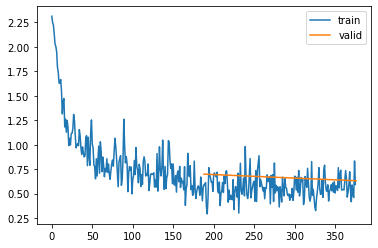

In [324]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

In [325]:
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [326]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.679,0.893,0,train
0.666,1.071,0,eval


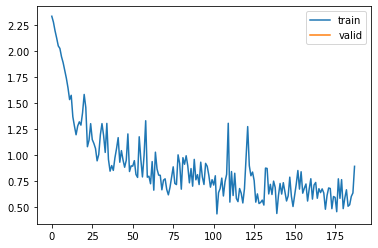

In [327]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## TrainLearner and MomentumLearner

In [328]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [332]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.713,0.783,0,train
0.762,0.579,0,eval


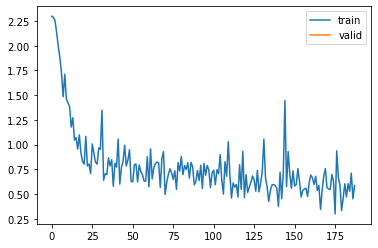

In [333]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

## LRFinderCB

In [337]:
learn.opt

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [338]:
learn.opt.param_groups

[{'params': [Parameter containing:
   tensor([[-0.03,  0.02,  0.02,  ...,  0.03,  0.01,  0.01],
           [-0.03, -0.00, -0.01,  ..., -0.03,  0.03, -0.02],
           [-0.01,  0.00,  0.00,  ...,  0.01, -0.03,  0.01],
           ...,
           [ 0.02, -0.01, -0.02,  ...,  0.01, -0.01, -0.01],
           [ 0.03, -0.00, -0.03,  ..., -0.02,  0.02, -0.02],
           [-0.01,  0.03,  0.03,  ..., -0.03, -0.00, -0.03]], requires_grad=True),
   Parameter containing:
   tensor([-0.02,  0.05,  0.11,  0.49, -0.18,  0.07,  0.23, -0.12, -0.28,  0.20,  0.14,  0.02, -0.02, -0.10, -0.26,  0.28, -0.01, -0.18,  0.12,
            0.26, -0.03, -0.04,  0.46, -0.02, -0.01,  0.16, -0.04,  0.17, -0.06,  0.01,  0.07,  0.13,  0.12,  0.02,  0.10,  0.04,  0.01, -0.18,
            0.05, -0.06, -0.37, -0.03, -0.10,  0.01, -0.02, -0.04,  0.21,  0.21, -0.01,  0.43], requires_grad=True),
   Parameter containing:
   tensor([[-0.12, -0.14, -0.27, -0.22, -0.14,  0.07,  0.02, -0.16, -0.13,  0.56,  0.05, -0.01, -0.29,  0.

In [340]:
learn.opt.param_groups[0]["params"]

[Parameter containing:
 tensor([[-0.03,  0.02,  0.02,  ...,  0.03,  0.01,  0.01],
         [-0.03, -0.00, -0.01,  ..., -0.03,  0.03, -0.02],
         [-0.01,  0.00,  0.00,  ...,  0.01, -0.03,  0.01],
         ...,
         [ 0.02, -0.01, -0.02,  ...,  0.01, -0.01, -0.01],
         [ 0.03, -0.00, -0.03,  ..., -0.02,  0.02, -0.02],
         [-0.01,  0.03,  0.03,  ..., -0.03, -0.00, -0.03]], requires_grad=True),
 Parameter containing:
 tensor([-0.02,  0.05,  0.11,  0.49, -0.18,  0.07,  0.23, -0.12, -0.28,  0.20,  0.14,  0.02, -0.02, -0.10, -0.26,  0.28, -0.01, -0.18,  0.12,
          0.26, -0.03, -0.04,  0.46, -0.02, -0.01,  0.16, -0.04,  0.17, -0.06,  0.01,  0.07,  0.13,  0.12,  0.02,  0.10,  0.04,  0.01, -0.18,
          0.05, -0.06, -0.37, -0.03, -0.10,  0.01, -0.02, -0.04,  0.21,  0.21, -0.01,  0.43], requires_grad=True),
 Parameter containing:
 tensor([[-0.12, -0.14, -0.27, -0.22, -0.14,  0.07,  0.02, -0.16, -0.13,  0.56,  0.05, -0.01, -0.29,  0.06, -0.38, -0.06,  0.05, -0.08,
      

In [343]:
learn.opt.param_groups[0]["lr"]

0.1

In [344]:
learn.loss

tensor(0.72)

In [346]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
        
    def before_fit(self, learn):
        self.lrs, self.losses = [], []
        self.min = math.inf
    
    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]["lr"])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g["lr"] *= self.lr_mult

In [347]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)

In [355]:
print(lrfind.lrs)

[0.0001, 0.00013000000000000002, 0.00016900000000000002, 0.00021970000000000003, 0.00028561000000000005, 0.0003712930000000001, 0.0004826809000000001, 0.0006274851700000002, 0.0008157307210000002, 0.0010604499373000004, 0.0013785849184900006, 0.0017921603940370008, 0.002329808512248101, 0.003028751065922532, 0.003937376385699291, 0.005118589301409079, 0.006654166091831803, 0.008650415919381343, 0.011245540695195747, 0.01461920290375447, 0.019004963774880812, 0.024706452907345057, 0.032118388779548576, 0.04175390541341315, 0.0542800770374371, 0.07056410014866824, 0.09173333019326871, 0.11925332925124932, 0.1550293280266241, 0.20153812643461136, 0.2619995643649948, 0.34059943367449325, 0.44277926377684124]


In [354]:
 print(lrfind.losses)

[tensor(2.32), tensor(2.29), tensor(2.33), tensor(2.30), tensor(2.29), tensor(2.30), tensor(2.29), tensor(2.31), tensor(2.31), tensor(2.29), tensor(2.32), tensor(2.31), tensor(2.31), tensor(2.30), tensor(2.27), tensor(2.26), tensor(2.24), tensor(2.22), tensor(2.20), tensor(2.19), tensor(2.16), tensor(2.13), tensor(2.08), tensor(2.03), tensor(1.89), tensor(1.83), tensor(1.55), tensor(1.54), tensor(1.54), tensor(1.57), tensor(1.21), tensor(2.86), tensor(4.56)]


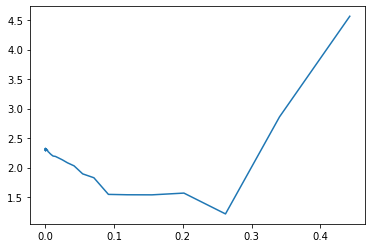

In [356]:
plt.plot(lrfind.lrs, lrfind.losses)

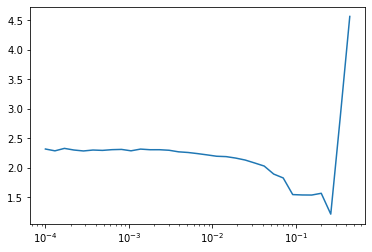

In [357]:
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale("log")

In [358]:
from torch.optim.lr_scheduler import ExponentialLR

```python

ExponentialLR??

---------------------------------------------------------------------------------------------------------------------------
Init signature: ExponentialLR(optimizer, gamma, last_epoch=-1, verbose=False)
Source:        
class ExponentialLR(_LRScheduler):
    """Decays the learning rate of each parameter group by gamma every epoch.
    When last_epoch=-1, sets initial lr as lr.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        gamma (float): Multiplicative factor of learning rate decay.
        last_epoch (int): The index of last epoch. Default: -1.
        verbose (bool): If ``True``, prints a message to stdout for
            each update. Default: ``False``.
    """

    def __init__(self, optimizer, gamma, last_epoch=-1, verbose=False):
        self.gamma = gamma
        super(ExponentialLR, self).__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        if self.last_epoch == 0:
            return [group['lr'] for group in self.optimizer.param_groups]
        return [group['lr'] * self.gamma
                for group in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return [base_lr * self.gamma ** self.last_epoch
                for base_lr in self.base_lrs]
File:           c:\programdata\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py
Type:           type
Subclasses:     
```

In [365]:
import numpy as np

print(math.isnan(12))
print(math.isnan(math.inf))
print(math.isnan(np.nan))

False
False
True


In [ ]:
# ExponentialLR.step??

In [369]:
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
        
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs, self.losses = [], []
        self.min = math.inf
        
    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()
        
    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale("log")

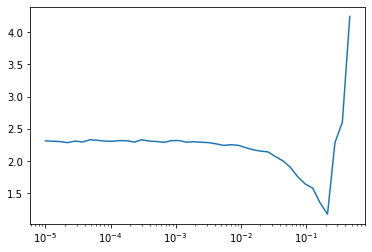

In [370]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [371]:
fc.patch

<function fastcore.basics.patch(f=None, *, as_prop=False, cls_method=False)>

```python
fc.patch??
------------------------------------------------------------------------------------------
Signature: fc.patch(f=None, *, as_prop=False, cls_method=False)
Source:   
def patch(f=None, *, as_prop=False, cls_method=False):
    "Decorator: add `f` to the first parameter's class (based on f's type annotations)"
    if f is None: return partial(patch, as_prop=as_prop, cls_method=cls_method)
    ann,glb,loc = get_annotations_ex(f)
    cls = union2tuple(eval_type(ann.pop('cls') if cls_method else next(iter(ann.values())), glb, loc))
    return patch_to(cls, as_prop=as_prop, cls_method=cls_method)(f)
File:      c:\programdata\anaconda3\lib\site-packages\fastcore\basics.py
Type:      function
```

In [378]:
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

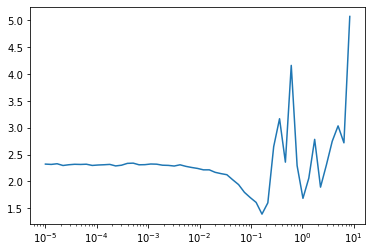

In [379]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()